In [1]:
import numpy as np
import pandas as pd
import re
import statistics
from collections import Counter
import random
random.seed(28)

import matplotlib.pyplot as plt
import seaborn as sns

# To generate dummies
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

In [2]:
# Loading the train data to understand how to clean
df = pd.read_csv("train.csv")
df.drop(columns="w", inplace=True)

# Cleaning Variables

## Explorative

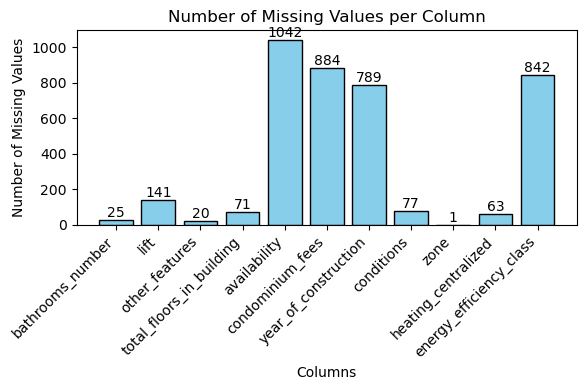

In [3]:
# Count the number of missing values in each column
missing_values_count = df.isnull().sum()

# Filter columns with at least 1 missing value
missing_values_count = missing_values_count[missing_values_count > 0]

# Create a bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(missing_values_count.index, missing_values_count, color='skyblue', edgecolor='black')
plt.title('Number of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add text annotations above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

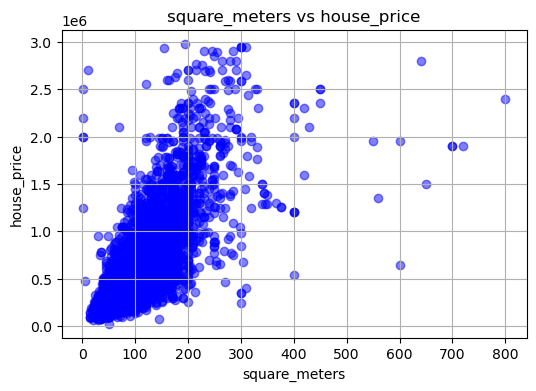

In [4]:
col1 = "square_meters"
col2 = 'y'

# Create a scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(df[col1], df[col2], alpha=0.5, color='blue')

# Add labels and title
plt.title(col1 + ' vs ' + "house_price")
plt.xlabel(col1)
plt.ylabel('house_price')

# Add grid
plt.grid(True)

# Show plot
#plt.show()

## Bathrooms

In [5]:
# Print number of missing values
print("Missing bathrooms_number:", df["bathrooms_number"].isna().sum())

def process_bathrooms(df):
    # Replace "3+" with 4
    df["bathrooms_number"] = df["bathrooms_number"].replace("3+", 4)
    
    # Create dummy variable for missing values
    df["bathrooms_number_missing"] = df["bathrooms_number"].isna()
    
    # Fill missing values with 0
    df["bathrooms_number"] = df["bathrooms_number"].fillna(0)
    
    # Convert dtype to int
    df["bathrooms_number"] = df["bathrooms_number"].astype(int)
    
    return df

df = process_bathrooms(df)
print(df["bathrooms_number"].dtype)
df["bathrooms_number"].value_counts()

Missing bathrooms_number: 25
int32


1    4907
2    2540
3     421
4     107
0      25
Name: bathrooms_number, dtype: int64

## Lift

In [6]:
def process_lift(df):

    # Convert lift column to string
    df["lift"] = df["lift"].astype(str)

    return df

df = process_lift(df)
# Print value counts of lift
print(df["lift"].dtype)
df["lift"].value_counts()

object


yes    6347
no     1512
nan     141
Name: lift, dtype: int64

## Rooms number

In [7]:
def process_rooms(df):

    df["rooms_number"] = df["rooms_number"].replace("5+", 6).astype(int)

    return df

df = process_rooms(df)
print(df["rooms_number"].dtype)
df["rooms_number"].value_counts()

int32


3    2971
2    2733
4    1231
1     457
5     396
6     212
Name: rooms_number, dtype: int64

## Other Features

In [8]:
def process_features(single_list):

    # Stripping for / and | 
    string_list = [part.strip() for part in re.split(r'[|/]', single_list)]
    
    # Replace "pvcexposure" and "pvcdouble"
    string_list = [s.replace("pvcexposure", "pvc exposure").replace("pvcdouble", "pvc double") for s in string_list]
    
    # Replace "balconies" and typos with "balcony" using regex
    pattern1 = r'(\d+)\s+balconies'
    pattern1 = r'.*balcon.*'
    string_list = [re.sub(pattern1, r'balcony', string) for string in string_list]
    
    # Split "pvc"
    pattern2 = r'(pvc)'
    string_list = [item.strip() for sublist in [[part for part in re.split(pattern2, string) if part] for string in string_list] for item in sublist]
    
    # Split strings at commas
    pattern3 = r',\s*'
    string_list = [part for sublist in [re.split(pattern3, string) for string in string_list] for part in sublist]
    
    # Split "exposure" followed by directions
    pattern4 = r'(?<=exposure) (south|north|west|east)'
    string_list = [re.split(pattern4, string) for string in string_list]
    string_list = [item for sublist in string_list for item in sublist if item]
    
    # Replace categories with too little information
    string_list = ["nan" if ((x == "disabled access") or (x == "property land1 balcony")) else x for x in string_list]
    
    return string_list

In [9]:
# Using the function to preprocess features
df["other_features"] = df["other_features"].astype(str)
df['other_features'] = df['other_features'].apply(process_features)

In [10]:
print(len(Counter([word for sublist in df['other_features'].to_list() for word in sublist]))) # should be 43
counter = Counter([word for sublist in df['other_features'].to_list() for word in sublist])
print('mean number of observations',statistics.mean(counter.values()))
counter

43
mean number of observations 1723.5348837209303


Counter({'security door': 6569,
         'centralized tv system': 5700,
         'optic fiber': 5354,
         'window frames in double glass': 5145,
         'balcony': 4797,
         'cellar': 4653,
         'video entryphone': 3953,
         'double exposure': 3629,
         'electric gate': 3605,
         'shared garden': 3475,
         'pvc': 3264,
         'full day concierge': 2968,
         'wood': 2236,
         'closet': 2030,
         'terrace': 1721,
         'furnished': 1716,
         'alarm system': 1707,
         'internal exposure': 1654,
         'partially furnished': 1337,
         'metal': 1318,
         'external exposure': 1295,
         'window frames in glass': 1221,
         'half-day concierge': 1097,
         'single tv system': 557,
         'window frames in triple glass': 452,
         'private garden': 445,
         'attic': 318,
         'fireplace': 232,
         'hydromassage': 214,
         'tavern': 207,
         'kitchen': 191,
         'exposure':

## Total Floors

In [11]:
def process_floors(df):
    df["total_floors_in_building_na"] = df["total_floors_in_building"].isna()
    df['total_floors_in_building'] = df['total_floors_in_building'].replace("1 floor", 1).replace(np.nan, 0).astype(int)
    df["total_floors_in_building"] = df["total_floors_in_building"].apply(lambda x: min(x, 9))
    return df

df = process_floors(df)

In [12]:
print(df['total_floors_in_building'].dtype)
df['total_floors_in_building'].value_counts()

int64


5    1467
4    1363
6    1189
8    1002
7     883
3     755
2     503
9     475
1     292
0      71
Name: total_floors_in_building, dtype: int64

## Parking

In [13]:
def process_parking(s):

    string = s.split(',')
    string = [part.strip() for part in string]

    #little expensive, put to "no"
    string = [s.replace("20 in shared parking", "no").replace("9 in shared parking", "no") for s in string]
    
    # strange_cases, multihouses
    string = [s.replace("2 in garage/box, 7 in shared parking", "strange_case").replace(
    "5 in shared parking", "strange_case").replace("7 in garage/box", "strange_case").replace(
        '7 in shared parking', "strange_case") for s in string]

    # legit case of many parkings
    string = [s.replace('6 in shared parking', "2 in shared parking").replace('4 in shared parking',"2 in shared parking")  for s in string]

    # Strange cases that cannot be handled in the test are put to category with 2
    def replace_strings(string):
        return ['strange_case' if re.search(r'\b(?:[3-9]\d*|\d{2,})\b', s) else s for s in string]
    
    string = replace_strings(string)
    
    return string

df["car_parking"] = df["car_parking"].apply(process_parking)

In [14]:
print(len(Counter([word for sublist in df['car_parking'].to_list() for word in sublist])))
Counter([word for sublist in df['car_parking'].to_list() for word in sublist])

6


Counter({'no': 6094,
         '1 in garage/box': 1241,
         '1 in shared parking': 578,
         '2 in garage/box': 220,
         '2 in shared parking': 49,
         'strange_case': 20})

## Availability

In [15]:
df['availability'] = df['availability'].astype(str)
def process_availability(string):
    if "from" in string:
        if int(string[-1]) >= 5:
            return "2025"
        if int(string[-6]) >= 7:
            return "late_2024"
        else:
            return 'early_2024'
    return string
df['availability'] = df["availability"].apply(process_availability)
print(df['availability'].dtype)
df['availability'].value_counts()

object


available     6665
nan           1042
early_2024     145
2025            88
late_2024       60
Name: availability, dtype: int64

## Condominium Fees

In [16]:
# Print number of missing values
print("Missing condominium fees:", df['condominium_fees'].isna().sum())

def process_condominium(df):

    # Convert 'condominium_fees' to numeric, coercing errors to NaN
    df['condominium_fees'] = pd.to_numeric(df['condominium_fees'], errors='coerce')

    # Set values exceeding 10,000 to NaN
    df.loc[df['condominium_fees'] > 10000, 'condominium_fees'] = np.nan
    
    # Create dummy variable for missing values in bathrooms_number
    df["condominium_missing"] = df['condominium_fees'].isna() 
    
    # Replace "No condominium fees" with 0 and convert to float
    df['condominium_fees'] = df['condominium_fees'].replace("No condominium fees", 0).astype(float)
    
    # Fill NaN values in 'condominium_fees' column with 0
    df['condominium_fees'].fillna(0, inplace=True)
    
    # Convert 'condominium_fees' to hundreds and cast to int
    df['condominium_fees'] = df['condominium_fees'].apply(lambda x: int(x / 100))

    # Replace values in [8,9] with 8
    mask1 = (df['condominium_fees'] >= 8) & (df['condominium_fees'] <= 9)
    df.loc[mask1, 'condominium_fees'] = 8
    
    # Replace values in [10,100] with 9
    mask2 = (df['condominium_fees'] >= 10) & (df['condominium_fees'] <= 100)
    df.loc[mask2, 'condominium_fees'] = 9
    
    # Replace values greater than 100 with 0, likely to be errors
    #df.loc[df['condominium_fees'] > 100, 'condominium_fees'] = 0
    
    return df

# Example usage:
df = process_condominium(df)
print(df["condominium_fees"].dtype)
df["condominium_fees"].value_counts()

Missing condominium fees: 884
int64


1    2503
0    2271
2    1829
3     683
4     279
5     213
6      77
9      65
7      57
8      23
Name: condominium_fees, dtype: int64

## Year of Construction

In [17]:
print("missing year:",df['year_of_construction'].isna().sum())

def process_year(df):
    
    df["year_of_construction"] = df["year_of_construction"].astype(str)
    df["year_of_construction"] = df["year_of_construction"].apply(lambda x: x[:3] if x else x)

    mask = (df['year_of_construction'].apply(lambda x: int(x) if x != "nan" else 0) >= 180) & (df['year_of_construction'].apply(lambda x: int(x) if x != "nan" else 1000) <= 187)
    df.loc[mask, 'year_of_construction'] = "1800s"
    df.loc[df['year_of_construction'].apply(lambda x: int(x) if x not in ["nan","1800s"] else 1000) <= 180, 'year_of_construction'] = "pre-1880s"
    
    return df

df = process_year(df)
print(df["year_of_construction"].dtype)
df["year_of_construction"].value_counts()

missing year: 789
object


196          2090
197           969
202           874
nan           789
195           668
193           561
190           411
200           344
194           285
201           281
192           280
198           175
199           121
1800s          48
191            42
pre-1880s      32
189            17
188            13
Name: year_of_construction, dtype: int64

## Conditions

In [18]:
print("missing conditions:",df['conditions'].isna().sum())

def process_conditions(df):
    df["conditions"] = df["conditions"].astype(str)
    return df

df = process_conditions(df)
print(df["conditions"].dtype)
df["conditions"].value_counts()

missing conditions: 77
object


excellent / refurbished      3255
good condition / liveable    2478
new / under construction     1377
to be refurbished             813
nan                            77
Name: conditions, dtype: int64

## Process Zone

In [19]:
#sorted(list(df["zone"].unique()))

In [20]:
df["zone"].value_counts(ascending=True)[:10]

quadrilatero della moda    1
via fra' cristoforo        1
parco lambro               1
via calizzano              2
cascina gobba              3
via canelli                3
scala - manzoni            4
qt8                        5
sant'ambrogio              6
lanza                      6
Name: zone, dtype: int64

In [21]:
def merge_zones(df):
    df["zone"] = df["zone"].astype(str)
    df["zone"] = df["zone"].replace("nan", 'città studi') # adding to most common category
    # Replace zones according to the mappings
    replacements = {
        'monte stella': 'qt8',
        'san vittore': "sant'ambrogio",
        "ca' granda": "greco - segnano",
        "quarto cagnino": "quinto romano",
        #"quintosole - chiaravalle": 'vigentino - fatima', # Maybe not a good idea because quite different
        "rogoredo": 'vigentino - fatima',
        "turati": 'brera',
        "borgogna - largo augusto": 'san babila',
        "ortica": 'quartiere forlanini',
        'porta nuova': 'repubblica',
        'melchiorre gioia': 'centrale',
        'trenno': 'san siro',
        'bovisasca': 'quarto oggiaro',
        'city life': 'amendola - buonarroti',
        'lanza': 'cadorna - castello',
        'figino': 'san siro',
        'scala - manzoni': 'duomo',
        'via canelli': 'lambrate',
        'cascina gobba': 'crescenzago',
        'via calizzano': 'comasina',
        "via fra' cristoforo": 'famagosta',
        "parco lambro": 'lambrate',
        "quadrilatero della moda": 'brera',
        # the followning are the missing for the test set
        "via marignano, 3": 'vigentino - fatima',
        "corso magenta": "sant'ambrogio",
        'largo caioroli 2' : "duomo",
        # further merging
        #"roserio" : 'quarto oggiaro',
        #"quartiere feltre" : "lambrate",
        #"istria" : 'maggiolina',
        #"quartiere olmi" : "baggio",
        #"zara" : "maggiolina",
        #"lorenteggio" : 'giambellino', 
        #"rubattino" : 'lambrate',
        #"muggiano" : "baggio",
        #'molise - cuoco' : "martini - insubria",
        #"tripoli - soderini": "piazza napoli",
        #"cadorna - castello" : "sant'ambrogio" ,
        #"bignami - ponale" : "villa san giovanni",
        #"pagano" : 'vercelli - wagner',
        #"arco della pace" : "arena",
        #"montenero" : 'piave - tricolore',
        #"prato centenaro" : "greco - segnano",
    }
    df['zone'] = df['zone'].replace(replacements)
    
    return df

# Applying the function:
df = merge_zones(df)
print(df["zone"].dtype)
len(df.zone.unique())

object


124

## Floor

In [22]:
def process_floor(df):
    
    df["mezzanine"] = df["floor"].apply(lambda x: 1 if x == "mezzanine" else 0) # Creating a dummy for mezzanine as not counting for square meters of the house
    df["semi-basement"] = df["floor"].apply(lambda x: 1 if x == "semi-basement" else 0)
    df["floor"] = df["floor"].replace({"mezzanine":-2, "semi-basement":-1, "ground floor":0}).astype(float)
    
    return df

df = process_floor(df)
print(df.floor.dtype)
df.floor.value_counts()

float64


 1.0    1701
 2.0    1270
 3.0    1074
 0.0     952
 4.0     804
-2.0     684
 5.0     561
 6.0     370
 7.0     246
 8.0     150
-1.0     148
 9.0      40
Name: floor, dtype: int64

## Heating

In [23]:
print('missing heating',df['heating_centralized'].isna().sum())

def process_heating(df):

    df["heating_centralized"] = df["heating_centralized"].astype(str)

    return df

df = process_heating(df)
print(df['heating_centralized'].dtype)
df['heating_centralized'].value_counts()

missing heating 63
object


central        5540
independent    2397
nan              63
Name: heating_centralized, dtype: int64

## Energy

In [24]:
def process_energy(df):

    df['energy_efficiency_class'] = df['energy_efficiency_class'].replace(",","nan").astype(str)
    
    df['energy_missing'] = df["energy_efficiency_class"].apply(lambda x: 1 if x == "nan" else 0)

    # Replace zones according to the mappings
    replacements = {
        'a': 1,
        "b": 2,
        "c": 3,
        "d": 4,
        "e": 5,
        "f": 6,
        "g": 7,
        'nan': 8,
    }
    df['energy_efficiency_class'] = df['energy_efficiency_class'].replace(replacements).astype(int)
    
    return df

df = process_energy(df)
#df['energy_missing'].value_counts()
print(df['energy_efficiency_class'].dtype)
df['energy_efficiency_class'].value_counts()

int32


7    2392
6    1456
5    1060
1     938
8     844
4     698
3     313
2     299
Name: energy_efficiency_class, dtype: int64

## Square meters

In [25]:
print("no missing,",df["square_meters"].isna().sum())
def process_sq(df):
    df["square_meters_error"] = df["square_meters"].apply(lambda x: 1 if x <= 13 else 0) # look like typos
    return df

no missing, 0


## Encoding catgeorical columns

In [26]:
categorical_cols1 = ["lift", "availability", "year_of_construction", "conditions", "zone", "heating_centralized"]
categorical_cols2 = ["other_features", "car_parking"]

In [27]:
def encode_1(df, categorical_cols):
    # Apply one-hot encoding to the non-numerical columns
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_data = encoder.fit_transform(df[categorical_cols])

    # Get the feature names for the encoded columns
    encoded_column_names = encoder.get_feature_names_out(input_features=categorical_cols)

    # Convert the encoded data back to a DataFrame
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)

    # Concatenate the encoded columns with the original DataFrame
    df_encoded = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

    return df_encoded

# Example usage:
df = encode_1(df, categorical_cols1)

C:\Users\lucak\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [28]:
def encode_2(df, column_names):
    for column_name in column_names:
        unique_strings = set(string for sublist in df[column_name] for string in sublist)
        for string in unique_strings:
            df[string] = df[column_name].apply(lambda x: 1 if string in x else 0)
    df = df.drop(columns=column_names)
    return df

# Example usage:
df_encoded = encode_2(df, categorical_cols2)

# Generating cleaned datasets

In [29]:
# Loading the train and test sets, taking aside the outcome variable
train = pd.read_csv('train.csv')
train.drop(columns="w", inplace=True)
y = np.log(train["y"])
train = train.drop('y', axis=1)
test = pd.read_csv("test.csv")

In [30]:
# Concatenating df
train = train.reindex(sorted(train.columns), axis=1).reset_index(drop=True)
test = test.reindex(sorted(train.columns), axis=1).reset_index(drop=True)
df = pd.concat([train, test], ignore_index=True)

In [31]:
def all_clean(df):
    df = process_bathrooms(df)
    df = process_lift(df)
    df = process_rooms(df)
    # Using the function to preprocess features
    df["other_features"] = df["other_features"].astype(str)
    df['other_features'] = df['other_features'].apply(process_features)
    df = process_floors(df)
    df["car_parking"] = df["car_parking"].apply(process_parking)
    df['availability'] = df['availability'].astype(str)
    df['availability'] = df["availability"].apply(process_availability)
    df = process_condominium(df)
    df = process_year(df)
    df = process_conditions(df)
    df = merge_zones(df)
    df = process_floor(df)
    df = process_heating(df)
    df = process_energy(df)
    df = process_sq(df)
    df = encode_1(df, categorical_cols1)
    df = encode_2(df, categorical_cols2)
    df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
    return df

In [32]:
df = all_clean(df)
train, test = df[:8000], df[8000:]
print(train.shape, test.shape)

C:\Users\lucak\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(8000, 221) (4800, 221)


In [33]:
train.to_csv('train_clean.csv', index=False)
test.to_csv('test_clean.csv', index=False)
y.to_csv('y.csv', index=False)